In [1]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error ,r2_score

# from utils.helper import fn_plot_confusion_matrix

In [2]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Note this function is specifically designed to plot Tensorflow training output
    Args:
      hist_df : pandas DataFrame with four columns
                For 'x' values, we will use index
                first column is accuracy
                Second column is loss
                third column is val_accuracy
                fourth column is val_loss
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) # instantiate plot

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
 
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification                                                                             
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [3]:
# Some basic parameters
inpDir = '../../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'fashion_MNIST' # location of the images
modelDir = '../models'
altName = 'Housing'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production


EPOCHS = 500 # number of cycles to run
ALPHA = 0.001 # learning rate
BATCH_SIZE = 32
PATIENCE = 30

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:
filePath =  "household_power_consumption.txt"
data_df = pd.read_csv(filePath, 
                      sep= ';', 
                      parse_dates={'dt': ['Date', 'Time']},
                     dayfirst=True,
                     low_memory=False,
                     na_values=['nan', '?'],
                     index_col='dt')
data_df.head()

C:\Users\duasp\AppData\Local\Temp\ipykernel_9560\3151924750.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data_df = pd.read_csv(filePath,


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [6]:
data = data_df.fillna(data_df.mean())

In [7]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122
Global_reactive_power,2049280.0,0.123714,0.112722,0.000,0.048,0.100,0.194,1.390
Voltage,2049280.0,240.839858,3.239987,223.200,238.990,241.010,242.890,254.150
Global_intensity,2049280.0,4.627759,4.444396,0.200,1.400,2.600,6.400,48.400
Sub_metering_1,2049280.0,1.121923,6.153031,0.000,0.000,0.000,0.000,88.000
Sub_metering_2,2049280.0,1.298520,5.822026,0.000,0.000,0.000,1.000,80.000
Sub_metering_3,2049280.0,6.458447,8.437154,0.000,0.000,1.000,17.000,31.000


In [8]:
df_sample = data_df.resample('h').mean()
df_sample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [9]:
scaler = MinMaxScaler()
df_sample['var1_t'] = df_sample['Global_active_power'].shift(-1)
df_sample = df_sample.rename({'Global_active_power' : 'var1',
                 'Global_reactive_power	': 'var2',
                 'Voltage': 'var3',
                 'Global_intensity': 'var4',
                 'Sub_metering_1': 'var5',
                 'Sub_metering_2': 'var6',
                 'Sub_metering_3': 'var7',}, axis=1)

df_sample = df_sample.dropna()
reframed = scaler.fit_transform(df_sample)
pd.DataFrame(reframed).head()

,0,1,2,3,4,5,6,7
0,0.636816,0.283776,0.337945,0.631157,0.0,0.011366,0.782418,0.545045
1,0.545045,0.088127,0.335501,0.541487,0.0,0.144652,0.782676,0.509006
2,0.509006,0.094957,0.283802,0.502152,0.0,0.030869,0.774169,0.488550
3,0.488550,0.081648,0.315987,0.481110,0.0,0.000000,0.778809,0.455597
4,0.455597,0.083705,0.434417,0.449904,0.0,0.008973,0.798917,0.322555


In [10]:
split = 365*24

train = reframed[:split]
test = reframed[split:]

X_train = train[:, :-1]
y_train = train[:, -1]

X_test = test[:, :-1]
y_test = test[:, -1]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8760, 7), (8760,), (25399, 7), (25399,))

In [11]:
X_train = X_train.reshape((X_train.shape[0],1 ,X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0],1 ,X_test.shape[1]))

X_train.shape, X_test.shape

((8760, 1, 7), (25399, 1, 7))

<h4>Prepare Model</h4>

In [13]:
input_shape = (X_train.shape[1], X_train.shape[2])
n_units = 512
dor1 = 0.2
dor2 = 0.5

model = tf.keras.models.Sequential()

model.add(tf.keras.Input(input_shape))
model.add(tf.keras.layers.LSTM(units=n_units, activation='tanh'))
model.add(tf.keras.layers.Dropout(dor1))

model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(dor2))

model.add(tf.keras.layers.Dense(units= 1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 512)            │     1,064,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,130,753 (4.31 MB)

 Trainable params: 1,130,753 (4.31 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# model(X_train[:1])

In [15]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
metrics= tf.keras.metrics.RootMeanSquaredError()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metrics])

In [16]:
filePath = "lstm.keras"
mcb =tf.keras.callbacks.ModelCheckpoint(filePath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
)

esch =tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    verbose=1,
    restore_best_weights=True,
)

In [17]:
history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    callbacks=[mcb,esch],
                    validation_data=(X_test, y_test))

Epoch 1/500
264/274 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0157 - root_mean_squared_error: 0.1245
Epoch 1: val_loss improved from inf to 0.00925, saving model to lstm.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0156 - root_mean_squared_error: 0.1241 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0962
Epoch 2/500
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109
Epoch 2: val_loss improved from 0.00925 to 0.00858, saving model to lstm.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 3/500
264/274 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - root_mean_squared_error: 0.1092
Epoch 3: val_loss did not improve from 0.00858
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 4/500
266/274 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

In [18]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,0.012806,0.113165,0.009250,0.096178
1,0.011623,0.107809,0.008580,0.092629
2,0.011406,0.106798,0.008689,0.093214
3,0.011045,0.105095,0.008597,0.092721
4,0.011051,0.105124,0.008331,0.091274


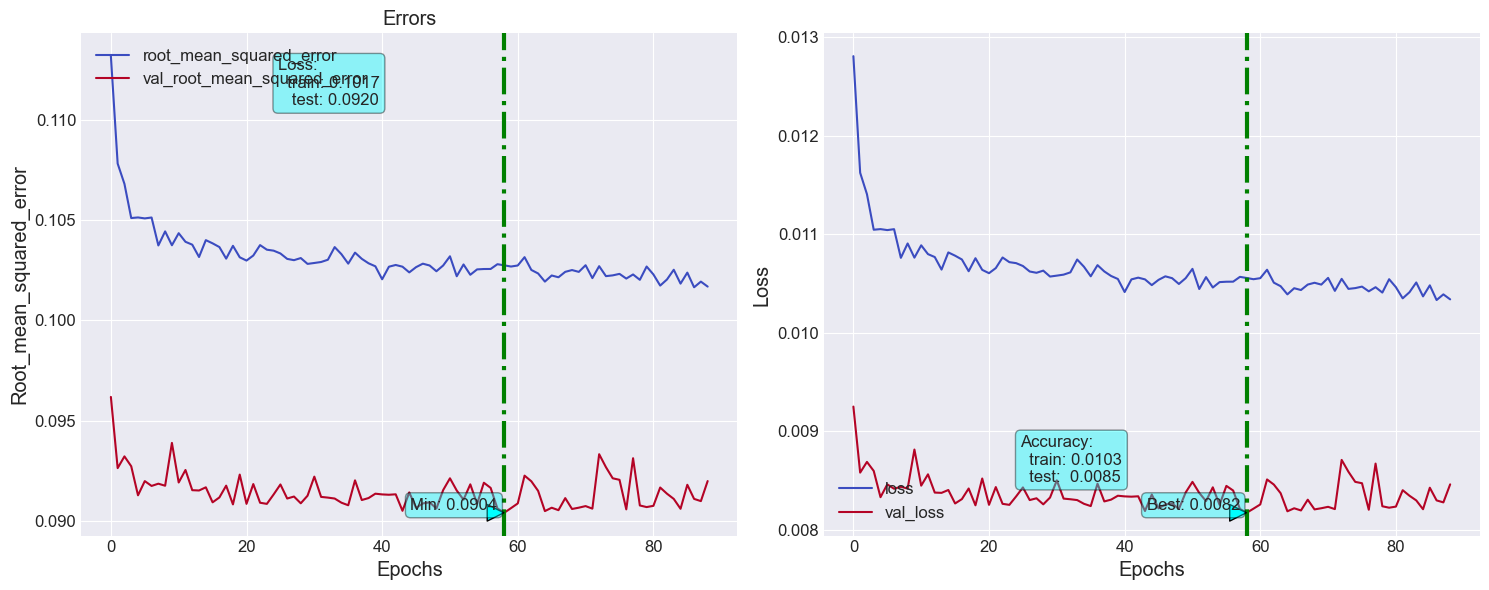

In [19]:
fn_plot_tf_hist(loss_df)

In [20]:
y_pred = model(X_test)

In [21]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

In [22]:
inv_x = np.concatenate((y_pred, X_test),axis = 1)
inv_x = scaler.inverse_transform(inv_x)

y_test = y_test.reshape((len(y_test) , 1))
inv_y = np.concatenate((y_test, X_test),axis = 1)
inv_y = scaler.inverse_transform(inv_y)

inv_y.shape

(25399, 8)

In [23]:
inv_y_pred = inv_x[:, 0]
inv_y_pred

array([1.32628143, 1.15398927, 1.54685953, ..., 1.7759359 , 1.8888949 ,
       1.40135612])

In [24]:
inv_y = inv_y[:, 0]
inv_y

array([1.33906667, 1.60146667, 1.8706    , ..., 1.65933333, 1.1637    ,
       0.93466667])

In [25]:
r2_score(inv_y, inv_y_pred)

0.5383586065070405